# Single Ring Neuron Experiment

## Imports

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import datetime as dt
import os

## Equations

### Output Transform Function (Sigmoid)
$$z_{r}=f(v_{i})=\frac{1}{1+e^{-\beta (v_{i} - \mu)}}$$
$$\beta = 10; \mu = 0.2$$

In [2]:
def transform(v, beta, mu):
    return 1 / (1 + (np.e ** ((-1*beta) * (v - mu))))

### Possible New Equations ###

Activation: $\frac{dv}{dt}=\frac{1}{\tau}(-\lambda uv+i);$
$\tau = 1.0; \lambda=10$

Deactivation 
$\frac{du}{dt}=-\rho u+\frac{z}{c};$
$\rho=1.0$

Output: $z=f(v)=\frac{1}{1+e^{-\beta (v - \mu)}};$
$\beta = 40; \mu = 0.1$

### Activity Equation
$$\frac{dv_i}{dt}=\frac{1}{\tau}(-\lambda v_i+i_1-\alpha u_i)$$ 
$$\tau = 1.0; \lambda=0.5; \alpha = 0.2$$

### Deactivation Equation
$$\frac{du_i}{dt}=-\rho u_i+\frac{z_i}{c_k}$$
$$\rho=0.2$$

In [3]:
def doodle(t, state, p):
    return [
        # (1 / p['tau']) * ((-1 * p['lambda'] * state[0]) + (p['i']) - (p['alpha'] * state[1])),
        (1 / p['tau']) * ((-1 * p['lambda'] * state[1] * state[0]) + (p['i'])), #- (p['alpha'] * state[1])),
        (-1 * p['rho'] * state[1]) + (transform(state[0], p['beta'], p['mu']) / p['c'])
    ]

## Hyperparameter Tuning

### Multi-trial U, or V, or Z plot

ValueError: `t_eval` must be 1-dimensional.

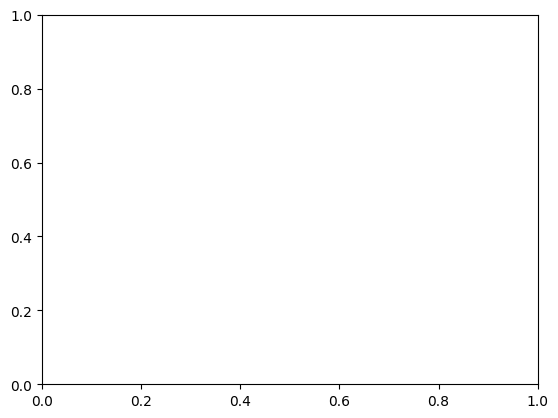

In [59]:
fig,ax = plt.subplots()
for c in [0.01, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]:
# for i in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 50]:
# for i in [0.1]:
    params = {
        'tau': 1.0,
        'lambda': 10.0,
        'i': 1.0,
        # 'alpha': 0.2,
        'rho': 0.5,
        'c': c,
        'beta': 40.0,
        'mu': 0.1
    }
    result = solve_ivp(fun=lambda t, state: doodle(t, state, params), t_span=(0,20), t_eval=t, y0=y0)
    # fig,ax = plt.subplots()
    # ax.plot(t,result.y[0].T,label=f'v with i={i}')
    # ax.plot(t,result.y[1].T,label=f'u with i={i}')
    ax.plot(t,transform(result.y[0], params['beta'], params['mu']).T,label=f'z with i={i}')
    ax.legend(loc='lower right')
    # ax.set_ylim([0, 1])
    ax.set_xlabel('t')
    ax.set_ylabel('z')
    # ax.set_title(f"Output (z) Over Varying i\ntau={params['tau']}|i={params['i']}|alpha={params['alpha']}|rho={params['rho']}|beta={params['beta']}|mu={params['mu']}".replace('.','p').replace('|',' - '))
    plt.tight_layout()
    # plt.savefig(f"plots\\tau={params['tau']}|lambda={params['lambda']}|i={params['i']}|alpha={params['alpha']}|rho={params['rho']}|c={params['c']}|beta={params['beta']}|mu={params['mu']}".replace('.','p').replace('|',' - '))
    # plt.show()

### Single Trial U-V-Z Plot

Text(0.5, 1.0, 'Single Ring Neuron Dynamics with Baseline Parameters\ntau=1p0 - lambda=100p0 - i=1p0 - rho=0p1 - c=0p3 - beta=50p0 - mu=0p1')

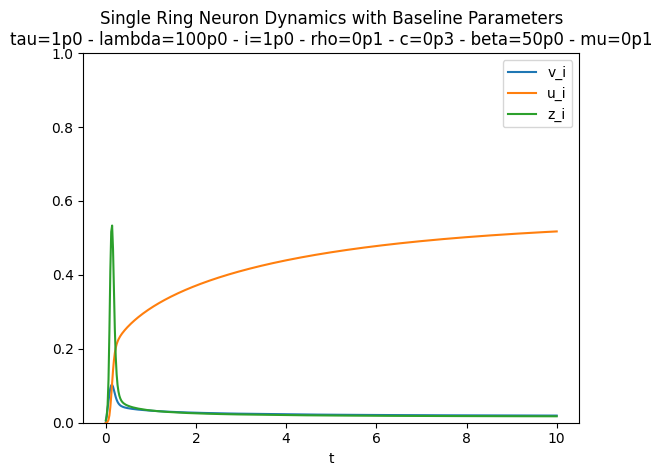

In [124]:
BASELINE_PARAMS = {
    'tau': 1.0,
    'lambda': 100.0,
    'i': 1.0,
    'rho': 0.1,
    'c': 0.3,
    'beta': 50.0,
    'mu': 0.1
}
t = np.linspace(0, 10, 500)
y0 = [0.0, 0.0]
result = solve_ivp(fun=lambda t, state: doodle(t, state, BASELINE_PARAMS), t_span=(0,20), t_eval=t, y0=y0)
fig,ax = plt.subplots()
ax.plot(t,result.y[0].T,label='v_i')
ax.plot(t,result.y[1].T,label='u_i')
ax.plot(t,transform(result.y[0], BASELINE_PARAMS['beta'], BASELINE_PARAMS['mu']).T,label='z_i')
ax.legend()
ax.set_ylim([0, 1])
ax.set_xlabel('t')
ax.set_title(f"Single Ring Neuron Dynamics with Baseline Parameters\ntau={BASELINE_PARAMS['tau']}|lambda={BASELINE_PARAMS['lambda']}|i={BASELINE_PARAMS['i']}|rho={BASELINE_PARAMS['rho']}|c={BASELINE_PARAMS['c']}|beta={BASELINE_PARAMS['beta']}|mu={BASELINE_PARAMS['mu']}".replace('.','p').replace('|',' - '))

### Phase Plane Trajectories over Nullclines

In [125]:
def create_frame(xs, ys, t, nullclines, gif_dir) -> None:
    '''
    :param xs list: a list of the x-values of the doodle
    :param ys list: a list of the y-values of the doodle
    :param t int: the current timestep in the doodle

    TODO file naming
    '''
    # plot nullclines in color
    COLORS = list(mcolors.TABLEAU_COLORS.values())
    if nullclines != []:
        for nc in range(len(nullclines)):
            plt.plot(nullclines[nc][0], nullclines[nc][1], color=COLORS[nc])

    plt.axvline(x=0, c="black", linewidth=0.5)
    plt.axhline(y=0, c="black", linewidth=0.5)
    
    # plot trajectory
    plt.plot(xs[:(t+1)], ys[:(t+1)], color = 'gray' )
    plt.plot(xs[t], ys[t], color = 'black', marker = 'o' )
    plt.xlim([-1, 1])
    plt.xlabel('v', fontsize = 14)
    plt.ylim([-1, 1])
    plt.ylabel('u', fontsize = 14)
    plt.title(f"Relationship between v and u at step {t}\nSingle Ring Neuron Dynamics with Baseline Parameters\ntau={BASELINE_PARAMS['tau']}|lambda={BASELINE_PARAMS['lambda']}|i={BASELINE_PARAMS['i']}|rho={BASELINE_PARAMS['rho']}|c={BASELINE_PARAMS['c']}|beta={BASELINE_PARAMS['beta']}|mu={BASELINE_PARAMS['mu']}".replace('.','p').replace('|',' - '),
            fontsize=14)
    plt.savefig(f'{gif_dir}\\img_{t}.png',
                transparent = False,
                facecolor = 'white'
            )
    plt.close()

In [126]:
params = {
    'tau': 1.0,
    'lambda': 100.0,
    'i': 1,
    'rho': 0.1,
    'c': 0.3,
    'beta': 50.0,
    'mu': 0.1
}

t = np.linspace(0, 10, 200)
y0 = [0.0, 0.0]
result = solve_ivp(fun=lambda t, state: doodle(t, state, params), t_span=(0,20), t_eval=t, y0=y0)

v = np.linspace(-1, 5, 600)
nullcline_1 = params['i'] / (params['lambda'] * v)
nullcline_2 = (1 / (params['rho'] * params['c'])) * (1 / (1 + np.exp(-1 * params['beta'] * (v - params['mu']))))

frames = []
dt_str = str(dt.datetime.now()).replace(':', '-').replace(' ', '_').split('.')[0]

gif_path = f'.\\plots\\gifs\\gifs_{dt_str}'

if not os.path.isdir(gif_path):
    os.makedirs(gif_path)

for t in range(len(result.t)):
    create_frame(result.y[0], result.y[1], t, [(v, nullcline_1), (v, nullcline_2)], gif_path)
    image = imageio.v2.imread(gif_path + f'\\img_{t}.png')
    frames.append(image)

imageio.mimsave(f'{gif_path}\\_output.gif', frames, duration=2)